In [1]:
# TRANSFER LEARNING WITH VGG16 - FLOWER CLASSIFICATION
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

In [2]:
(train_ds, test_ds), info = tfds.load( 'tf_flowers', split=['train[:70%]', 'train[70%:]'], as_supervised=True, with_info=True)


In [3]:
print("Total Images")
print(len(train_ds) )
print(len(test_ds))

2569
1101


In [4]:
info.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [5]:
class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

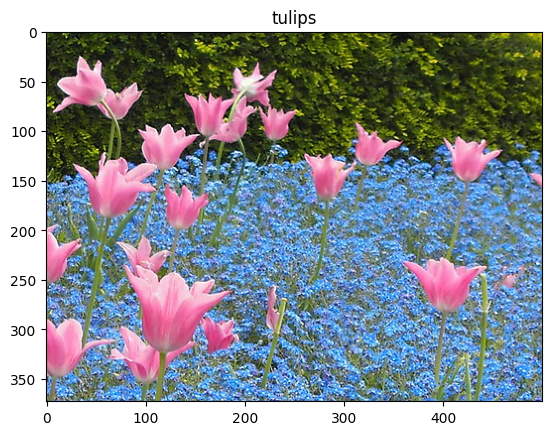

In [51]:
batch = random.choice(list(train_ds.batch(1)))
img, label = batch
n = random.randint(0, len(img)-1)
plt.title(class_names[label[n]])
plt.imshow(img[n])
plt.show()

In [8]:
# 2. Preprocess for VGG16
def preprocess(image, label):
    image = tf.image.resize(image, [128, 128])  # FIXED SIZE INPUT TO VGG
    image = tf.keras.applications.vgg16.preprocess_input(image) # RGB TO BGR , FOR VGG IMAGENET MODEL
    return image, label

BATCH_SIZE = 16
train_data = train_ds.map(preprocess).batch(BATCH_SIZE)
test_data = test_ds.map(preprocess).batch(BATCH_SIZE)

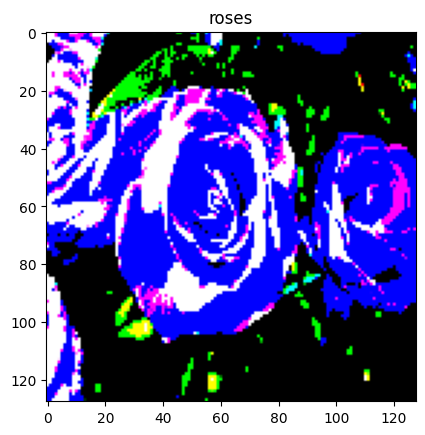

In [42]:
# Random batch + random sample
batch = random.choice(list(train_data))
img, label = batch
n = random.randint(0, len(img)-1)
plt.title(class_names[label[n]])
plt.imshow(img[n])
plt.show()

In [10]:
# 3. Create Transfer Learning Model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze VGG16 layers

In [11]:
# VGG16 extracts features, our layers learn to classify flowers using those features!
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 flower types
])

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,997 (56.39 MB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/2
161/161 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.5864 - loss: 2.5926 - val_accuracy: 0.7811 - val_loss: 0.8674
Epoch 2/2
161/161 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.8663 - loss: 0.4468 - val_accuracy: 0.8129 - val_loss: 0.7644


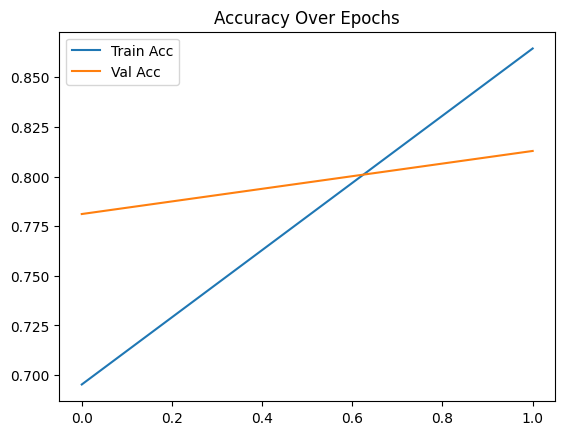

In [13]:
# 4. Train and visualize
history = model.fit(train_data, epochs=2, validation_data=test_data)

# Quick plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

In [15]:
# 5. Evaluate
test_loss, test_accuracy = model.evaluate(test_data)
print(f"🎯 FINAL TEST ACCURACY: {test_accuracy:.2%}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8165 - loss: 0.7108
🎯 FINAL TEST ACCURACY: 82.38%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


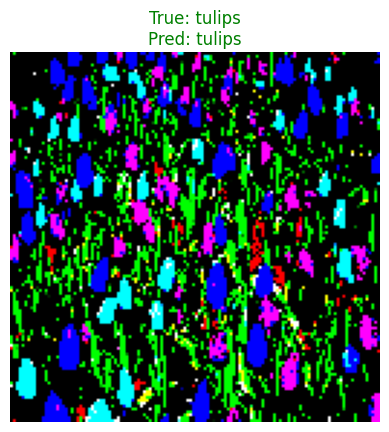

In [35]:
# Random batch + random sample
batch = random.choice(list(test_data))
img, label = batch
n = random.randint(0, len(img)-1)

plt.imshow(img[n])
true = class_names[label[n]]
pred = class_names[np.argmax(model.predict(img)[n])]  # model predict bathwise , only.
plt.title(f'True: {true}\nPred: {pred}', color='green' if true == pred else 'red')
plt.axis('off')
plt.show()